## Analysis

In [ ]:
%load_ext autoreload
%autoreload 2

In [88]:
import pandas as pd
from PIL import Image
from scipy.stats import pearsonr
from utils.get_unique_values import get_unique_values
from utils.remove_duplicates import unzip_fn
from utils.show_tile_images import show_tile_images
import zipfile
import json
from utils.visualize_bboxes_on_image import draw_text_on_image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import tqdm as tqdm
from functools import cache
from utils.flatten import flatten

In [ ]:
# !GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/spaces/mckabue/document-similarity-search-using-visual-layout-features --depth=1

# !wget https://huggingface.co/spaces/mckabue/document-similarity-search-using-visual-layout-features/resolve/main/data/processed/RVL-CDIP-invoice/vectors.json.zip -P ./data/processed/RVL-CDIP-invoice/



# import sys
# sys.path.insert(0, './document-similarity-search-using-visual-layout-features')

In [ ]:
# import os
# vectors_chunks = os.listdir('/content/document-similarity-search-using-visual-layout-features/data/processed/RVL-CDIP-invoice/vectors.json.zip.chunks')
# vectors_chunks.sort(key=lambda x: int(x.split('-')[0]))
# vectors_chunks

In [13]:
vectors_df = pd.read_json('./data/local-data/processed/RVL-CDIP-invoice/vectors.json.zip')
vectors_df

document_image                                   predicted_bboxes  \
0              0.png  [[29.3435668945, 643.4645996094, 739.842041015...   
1              1.png  [[39.7452430725, 49.9780197144, 781.0, 602.479...   
2              2.png  [[103.5238952637, 594.1181030273, 113.16088867...   
3              3.png  [[88.863067627, 108.4031677246, 396.8055114746...   
4              4.png  [[82.0789871216, 45.9043922424, 709.9898071289...   
...              ...                                                ...   
19942      19942.png  [[191.2108917236, 260.6972351074, 370.19641113...   
19943      19943.png  [[256.7819213867, 81.0255050659, 392.073303222...   
19944      19944.png  [[124.7773895264, 139.6303100586, 802.0, 658.7...   
19945      19945.png  [[14.6810312271, 343.2859802246, 736.022338867...   
19946      19946.png  [[26.7576179504, 270.6901855469, 751.377380371...   

                                        predicted_scores  \
0      [0.7836931944000001, 0.6475759149, 0.599450826...   
1      [0.4839464724, 0.47660487890000003, 0.46349054...   
2      [0.7848277092, 0.7287962437000001, 0.709546744...   
3      [0.6572625637, 0.6462457776, 0.6340482235, 0.5...   
4      [0.8355703354, 0.6515532136000001, 0.562511444...   
...                                                  ...   
19942  [0.6322918534, 0.5738079548, 0.541682004900000...   
19943  [0.6657200456, 0.4550766945, 0.4131726623, 0.4...   
19944  [0.6754669547000001, 0.5447676778, 0.477854847...   
19945  [0.5109338164, 0.3732797503, 0.3711174726, 0.2...   
19946  [0.693007946, 0.3177033067, 0.2668364942, 0.26...   

                                        predicted_labels  \
0      [Table, Table, Text, Section-header, Section-h...   
1      [Table, Text, Table, Table, Caption, Text, Tex...   
2      [Title, Title, Table, Title, Title, Title, Tit...   
3      [Text, Text, Text, Picture, Text, Title, Text,...   
4      [Table, Table, Title, Picture, Section-header,...   
...                                                  ...   
19942  [Text, Section-header, Text, Text, Text, Table...   
19943  [Title, Text, Table, Text, Caption, Table, Pic...   
19944  [Table, Page-footer, Page-footer, Table, Secti...   
19945  [Picture, Table, Text, Text, Text, Text, Table...   
19946  [Table, Caption, Picture, Picture, Title, Titl...   

                                                 vectors  \
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                  ...   
19942  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
19943  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
19944  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
19945  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
19946  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        weighted_vectors  \
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                  ...   
19942  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
19943  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
19944  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
19945  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
19946  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                reduced_predicted_bboxes  \
0      [[29.3435668945, 643.4645996094, 739.842041015...   
1      [[39.7452430725, 49.9780197144, 781.0, 602.479...   
2      [[103.5238952637, 594.1181030273, 

In [ ]:
# https://gemini.google.com/app/8cd4389df12d29e6

# https://chat.openai.com/c/a345a9ec-9238-4089-a6c0-bb4d375148eb

### Correlation

In [10]:
unique_values = get_unique_values(start=0.17, end=1, count=10*1000)

def get_stats(index: int):
    vectors = vectors_df.loc[index, 'vectors']
    weighted_vectors = vectors_df.loc[index, 'weighted_vectors']
    reduced_vectors = vectors_df.loc[index, 'reduced_vectors']
    reduced_weighted_vectors = vectors_df.loc[index, 'reduced_weighted_vectors']
    non_zero_vectors, non_zero_uniques = unzip_fn([(vector, unique) for vector, unique in zip(vectors, unique_values) if vector > 0]) if len([i for i in vectors if i > 0]) > 0 else ([], [])

    non_zero_vectors__uniques  = pearsonr(non_zero_vectors, non_zero_uniques) if len(non_zero_vectors) > 0 else [0,1]
    vectors___unique_values = pearsonr(vectors, unique_values)
    vectors___weighted_vectors = pearsonr(vectors, weighted_vectors)
    vectors___reduced_vectors = pearsonr(vectors, reduced_vectors)
    vectors___reduced_weighted_vectors = pearsonr(vectors, reduced_weighted_vectors)
    weighted_vectors___reduced_vectors = pearsonr(weighted_vectors, reduced_vectors)
    weighted_vectors___reduced_weighted_vectors = pearsonr(weighted_vectors, reduced_weighted_vectors)
    reduced_vectors___reduced_weighted_vectors = pearsonr(weighted_vectors, reduced_weighted_vectors)

    return {
        'non_zero_vectors__uniques': non_zero_vectors__uniques,
        'vectors___unique_values': vectors___unique_values,
        'vectors___weighted_vectors': vectors___weighted_vectors,
        'vectors___reduced_vectors': vectors___reduced_vectors,
        'vectors___reduced_weighted_vectors': vectors___reduced_weighted_vectors,
        'weighted_vectors___reduced_vectors': weighted_vectors___reduced_vectors,
        'weighted_vectors___reduced_weighted_vectors': weighted_vectors___reduced_weighted_vectors,
        'reduced_vectors___reduced_weighted_vectors': reduced_vectors___reduced_weighted_vectors,
    }

from matplotlib import pyplot as plt
from scipy.signal import convolve
kernel = np.array([0.25, 0.5, 0.25])  # Example kernel for simple averaging

def smooth_vector(vector):
    # Perform convolution
    smoothed_vector = convolve(vector, kernel, mode='same') / sum(kernel)
    return smoothed_vector

def get_modified_stats(image_1_index: int, image_2_index: int, vector_column: str = 'vectors', plot = False):
    image_1_values = vectors_df.loc[image_1_index, vector_column]
    image_2_values = vectors_df.loc[image_2_index, vector_column]

    image_1_matrix = np.array(image_1_values)
    image_2_matrix = np.array(image_2_values)

    vector_1_zero_indices = image_1_matrix == 0
    vector_2_zero_indices = image_2_matrix == 0

    image_1_matrix[vector_1_zero_indices] = unique_values[vector_1_zero_indices]
    image_2_matrix[vector_2_zero_indices] = unique_values[vector_2_zero_indices]

    _old_pearsonr = pearsonr(image_1_values, image_2_values)
    [[_old_cosine_similarity]] = cosine_similarity([image_1_values], [image_2_values])
    _pearsonr = pearsonr(image_1_matrix, image_2_matrix)
    [[_cosine_similarity]] = cosine_similarity([image_1_matrix], [image_2_matrix])

    image_1_matrix_smooth = smooth_vector(image_1_matrix)
    image_2_matrix_smooth = smooth_vector(image_2_matrix)
    _pearsonr_smooth = pearsonr(image_1_matrix_smooth, image_2_matrix)
    [[_cosine_similarity_smooth]] = cosine_similarity([image_1_matrix_smooth], [image_2_matrix])

    permuted_indices = np.random.permutation(len(image_1_matrix))
    _pearsonr_random = pearsonr(image_1_matrix[permuted_indices], image_2_matrix[permuted_indices])
    [[_cosine_similarity_random]] = cosine_similarity([image_1_matrix[permuted_indices]], [image_2_matrix[permuted_indices]])

    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(image_1_values, label='image_1_values', color = 'red')
        plt.plot(image_1_matrix_smooth, label='image_1_matrix_smooth', color = 'blue')
        # plt.plot(image_1_matrix, label='image_1_matrix', linestyle='--', color = 'blue')
        # plt.plot(image_1_matrix_smooth, label='image_1_matrix_smooth', linestyle='--', color = "green")
        plt.show()

    return {
        'old_pearsonr'              : f'{round(_old_pearsonr.statistic, 4)} - {_old_pearsonr.pvalue}',
        'old_cosine_similarity'     : round(_old_cosine_similarity, 4),
        'pearsonr'                  : f'{round(_pearsonr.statistic, 4)} - {_pearsonr.pvalue}',
        'cosine_similarity'         : round(_cosine_similarity, 4),
        'pearsonr_smooth'           : f'{round(_pearsonr_smooth.statistic, 4)} - {_pearsonr_smooth.pvalue}',
        'cosine_similarity_smooth'  : round(_cosine_similarity_smooth, 4),
        'pearsonr_random'           : f'{round(_pearsonr_random.statistic, 4)} - {_pearsonr_random.pvalue}',
        'cosine_similarity_random'  : round(_cosine_similarity_random, 4),
    }


In [ ]:
get_stats(19569)

In [ ]:
correlation_results = []
for i in tqdm.tqdm(range(len(correlation_results), len(vectors_df))):
    correlation_results.append(get_stats(i))

In [ ]:
columns = list(correlation_results[0].keys())
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.flatten()
for i, column in enumerate(columns):
    ax = axes[i]
    ax.hist([j[column][0] for j in correlation_results], bins=100)
    ax.set_title(column)

<hr/>

In [4]:
# vector_columns = ['vectors_column', 'weighted_vectors_column', 'reduced_vectors_column', 'reduced_weighted_vectors_column']
# similarities_json = {}
# for vector_column in tqdm.tqdm(vector_columns):
#     with  zipfile.ZipFile(f'./data/local-data/processed/RVL-CDIP-invoice/cosine_similarity_scores/{vector_column}.json.zip', "r") as zip_ref:
#         similarity_vectors_json = json.loads(zip_ref.read(zip_ref.filelist[0].filename))
#         similarities_json[vector_column] = similarity_vectors_json
@cache
def get_similarities(filter, vector_column: str = 'vectors_column'):
    with  zipfile.ZipFile(f'./data/local-data/processed/RVL-CDIP-invoice/cosine_similarity_scores/{vector_column}.json.zip', "r") as zip_ref:
        similarity_vectors_json = json.loads(zip_ref.read(zip_ref.filelist[0].filename))
    results = [value for value in tqdm.tqdm(similarity_vectors_json) if (filter(value) if filter else True)]
    results.sort(key=lambda similarity: similarity['cosine_similarity_score'], reverse=True)
    similarity_vectors_json = None
    return results

In [5]:
top_matches = get_similarities(
    lambda similarity: similarity['cosine_similarity_score'] > 0.8 and  similarity['document_image_1'] != similarity['document_image_2'], 
    'vectors_column')

100%|██████████| 198951378/198951378 [00:58<00:00, 3401285.59it/s]


In [233]:
def get_image(filename: str):
    return Image.open(f'./data/local-data/raw/RVL-CDIP-invoice/{filename}')

def print_matches(matches, *, per_side = 1, figsize = None):
    images = [
        [
            get_image(match['document_image_1']), 
            get_image(match['document_image_2']),
            # draw_text_on_image(
            #     Image.new("RGB", (800, 1200), 'white'),
            #     [100, 100],
            #     json.dumps(
            #         get_modified_stats(
            #             int(matches[i]['document_image_1'].split('.')[0]), 
            #             int(matches[i]['document_image_2'].split('.')[0]), 
            #             'vectors'), 
            #         indent=4),
            #     label_text_size=40,
            #     label_fill_color='white',
            # ),
        ]
        for match
        in matches
    ]
    titles = [
        [
            # f"{match['document_image_1']}, Similarity - {round(match['cosine_similarity_score'], 4)}", 
            match['document_image_1'],
            match['document_image_2'],
            # 'More Statistics',
        ]
        for match
        in matches
    ]
    width_parts = len(images[0]) * per_side
    tile_image = show_tile_images(
        images = flatten(images),
        titles = flatten(titles),
        width_parts = width_parts,
        figsize = figsize or (10.2 * width_parts, 12 * (len(images) / width_parts)),
        space = 2,
        pad = True,
        figcolor = '#d3eddd',
        title_color = 'white',
        title_background_color = 'black',
        title_font_size = 25)
    return tile_image

# print_matches(top_matches[0:1], figsize=(10, 7))

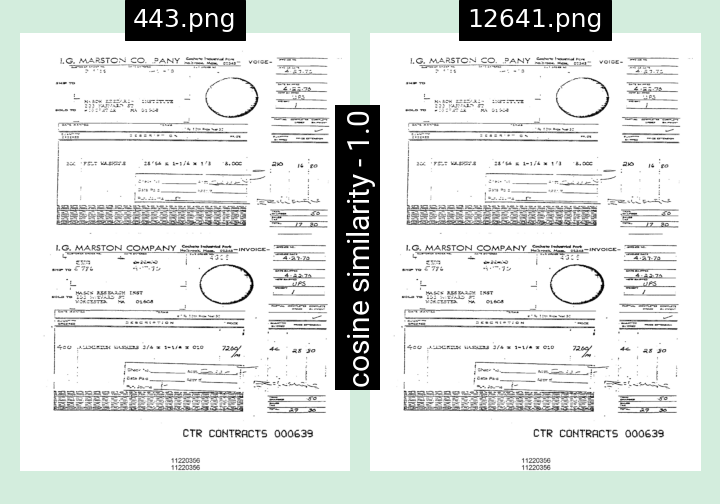

In [236]:
draw_text_on_image(
    print_matches([top_matches[0]], figsize=(10, 7)),
    [330, 335],
    f"cosine similarity - {round(top_matches[0]['cosine_similarity_score'], 4)}",
    label_text_size=30,
    label_fill_color='black',
    label_text_color='white',
    label_rotate_angle = 90,
    label_text_padding = 2
)
    

In [ ]:
# len([i for i in top_matches if i['cosine_similarity_score'] < 1 and i['cosine_similarity_score'] > 0.99])
# len([i for i in top_matches if i['cosine_similarity_score'] >= 1])
# import random
# import shutil
# 
# for matches in (top_matches[0:2] + random.sample([i for i in top_matches], 8)):
#     document_image_1 = matches['document_image_1']
#     document_image_2 = matches['document_image_2']
#     shutil.copyfile(f'./data/local-data/raw/RVL-CDIP-invoice/{document_image_1}', f'./demo-examples/{document_image_1}')
#     shutil.copyfile(f'./data/local-data/raw/RVL-CDIP-invoice/{document_image_2}', f'./demo-examples/{document_image_2}')

In [ ]:
almost_similar = [similarity for similarity in 
    similarity_vectors_json 
    if similarity['cosine_similarity_score'] > 0.9 and similarity['cosine_similarity_score'] < 1.0]
almost_similar.sort(key=lambda similarity: similarity['cosine_similarity_score'], reverse=True)

In [ ]:
print_matches(almost_similar, 5, start=0)

In [ ]:
from main import app
import os

model_path = '../detectron2-layout-parser/model_final.pth'
config_path = '../detectron2-layout-parser/config.yaml'

examples = [f'./demo-examples/{filename}' for filename in os.listdir('./demo-examples/')]
app(model_path=model_path, config_path=config_path, examples=examples, debug=True)

In [ ]:
import os
from PIL import Image
import layoutparser as lp
from utils.get_features import get_features

documents = os.listdir('./data/local-data/raw/RVL-CDIP-invoice')
# model_path = './model/trained_model/model_final.pth'
# config_path = './model/trained_model/config.yaml'
model_path = '../detectron2-layout-parser/model_final.pth'
config_path = '../detectron2-layout-parser/config.yaml'
label_map = {0: 'Caption', 1: 'Footnote', 2: 'Formula', 3: 'List-item', 
             4: 'Page-footer', 5: 'Page-header', 6: 'Picture', 
             7: 'Section-header', 8: 'Table', 9: 'Text', 10: 'Title'}
model = lp.Detectron2LayoutModel(
    config_path=config_path,
    model_path=model_path,
    label_map=label_map)

for document in documents[0:1]:
    features = get_features(
        image=Image.open(f'./data/local-data/raw/RVL-CDIP-invoice/{document}'),
        model=model,
        label_names=list(label_map.values()),
        width_parts=100,
        height_parts=100)

In [ ]:
all([column in vectors_df.columns for column in features.keys()])

In [ ]:
list(features.keys())

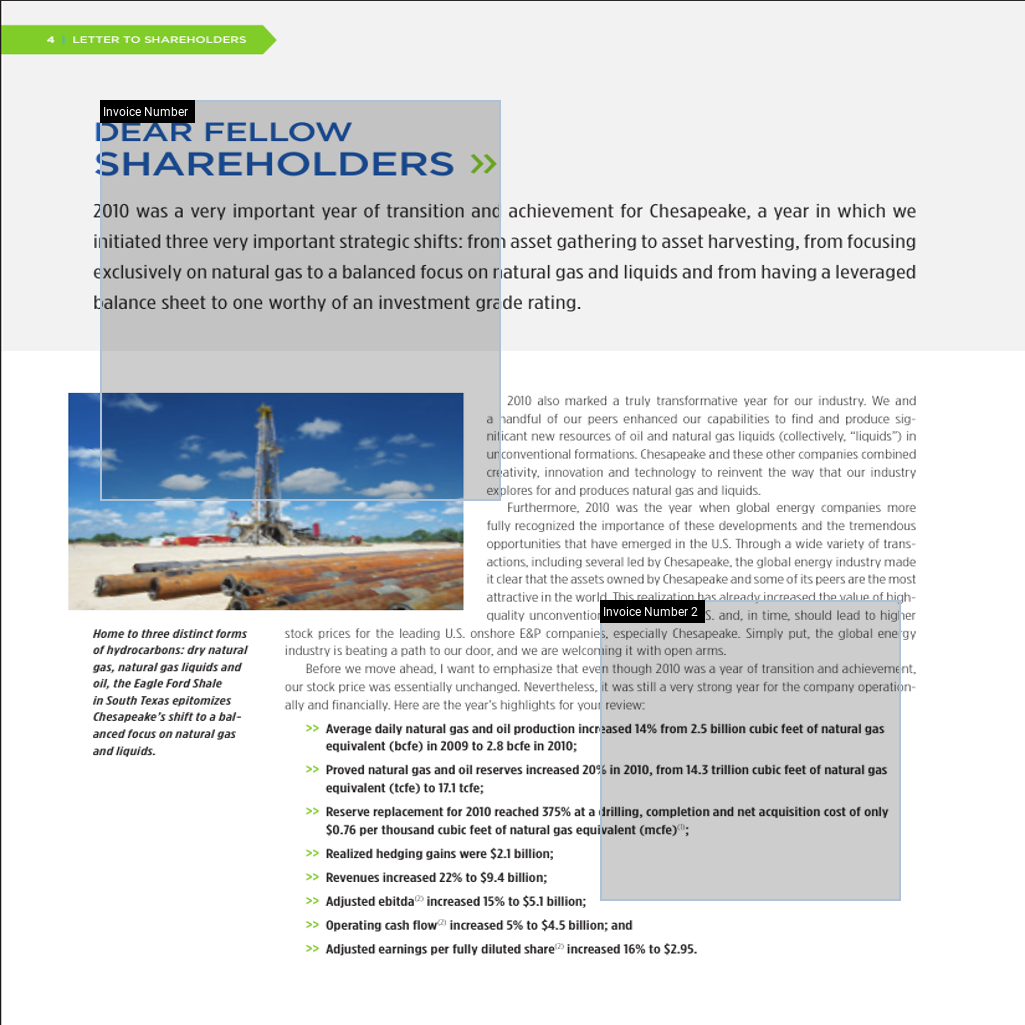

In [192]:
from utils.visualize_bboxes_on_image import visualize_bboxes_on_image

image = Image.open('/Users/charleskabue/document-similarity-search/detectron2-layout-parser/example.3.jpg')
visualize_bboxes_on_image_kwargs = {
    'label_text_color': 'white',
    'label_fill_color': 'black',
    'label_text_size': 12,
    'label_text_padding': 3,
    'label_rectangle_left_margin': 0,
    'label_rectangle_top_margin': 0,
    'bbox_outline_color': '#acc2d9', # alpha runs from 0 to 255
    'bbox_fill_color': (0, 0, 0, 50), # alpha runs from 0 to 255
}
visualize_bboxes_on_image(
    image,
    [[100, 100, 500, 500], [600, 600, 900, 900]],
    ['Invoice Number', 'Invoice Number 2'],
    **visualize_bboxes_on_image_kwargs
)

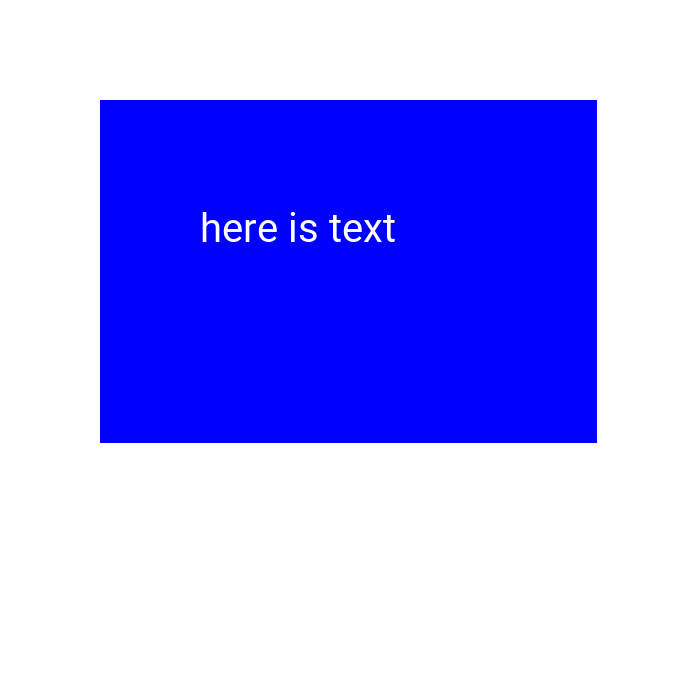

In [191]:
draw_text_on_image(
    Image.new("RGB", (700, 700), 'white'),
    [100, 100],
    'here is text',
    label_text_size=40,
    label_fill_color='blue',
    label_text_color = 'white',
    label_text_padding = 100)

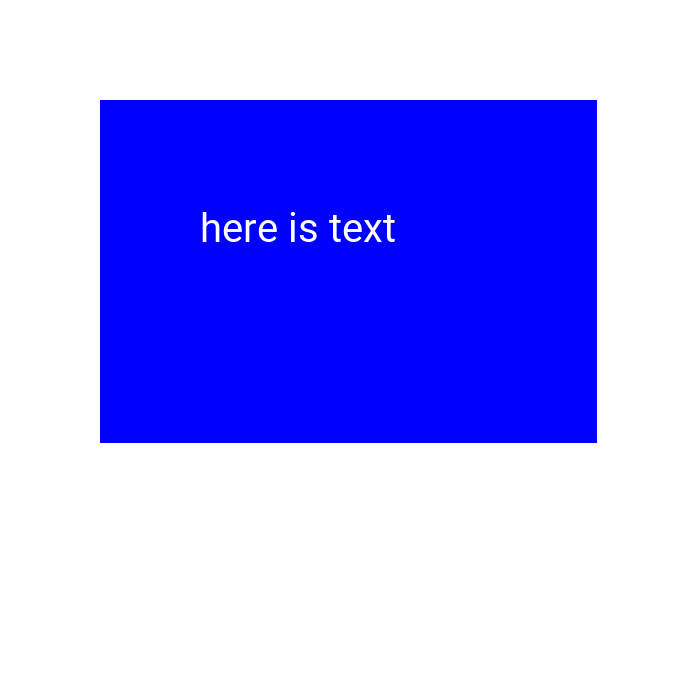

In [175]:
draw_text_on_image(
    Image.new("RGB", (700, 700), 'white'),
    [100, 100],
    'here is text',
    label_text_size=40,
    label_fill_color='blue',
    label_text_color = 'white',
    label_text_padding = 100)

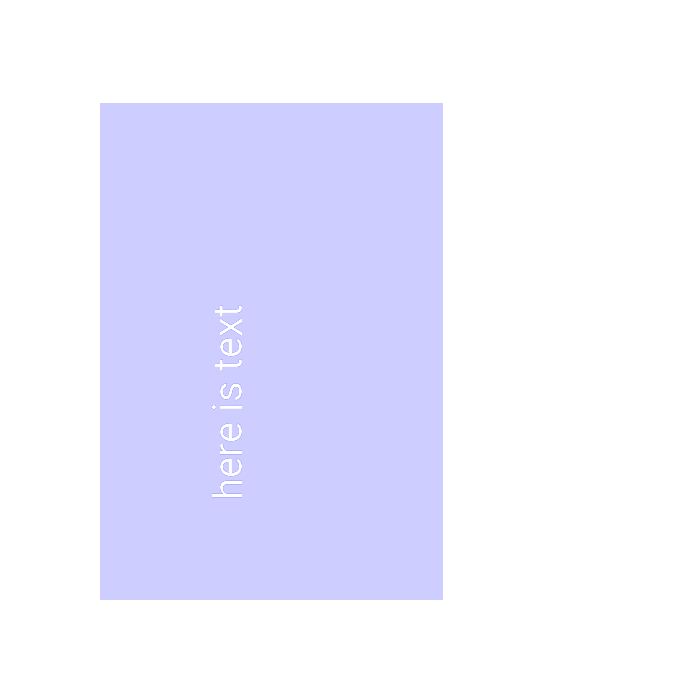

In [173]:
from utils.visualize_bboxes_on_image import draw_text_on_image

draw_text_on_image(
    Image.new("RGB", (700, 700), 'white'),
    [100, 100],
    'here is text',
    label_text_size=40,
    label_fill_color=('blue', 50),
    label_text_color = 'white',
    label_text_padding = 100,
    label_rotate_angle = 90)